Оказалось, что лучшим решением на правате был самый тупой бейзлан, а я просто неправильно валидировался. Я до сих пор не понимаю, почему это так(

Это решение дает 0.87126 на private и 0.86842 на public. Я же в качестве финального решения использовал решение из tuned baseline.ipynb

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import operator
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Word'] = train['Word'].apply(lambda x: x.lower())
test['Word'] = test['Word'].apply(lambda x: x.lower())

#удалим дубликаты и мусор
train.drop_duplicates(inplace = True)
train = train.loc[~train.Word.isin(set(train[train.Label == 1].Word.values) & set(train[train.Label == 0].Word.values))]
ss = pd.read_csv('sample_submission.csv')

In [3]:
n = 18
features = train['Word'].apply(lambda s: \
                                [ord(i) for i in s[:min(len(s),n)]] + [None for i in range(max(0,n-len(s)))]).tolist()
train.reset_index(drop=True, inplace=True)
train = train.join(pd.DataFrame(features, columns=[f'feature_{i}' for i in range(n)]))

import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 0    
}

x_train = train[[f'feature_{i}' for i in range(n)]]
y_train = train[['Label']]
x_train.fillna(np.nan, inplace=True)
dtrain = xgb.DMatrix(x_train, y_train)

/home/kondrat/.conda/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [4]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000,
    verbose_eval=50, show_stdv=True, stratified=True, nfold = 3)

[0]	train-auc:0.707843+0.0022848	test-auc:0.702803+0.00660271
[50]	train-auc:0.802+0.000472858	test-auc:0.788566+0.00529924
[100]	train-auc:0.844258+0.00137139	test-auc:0.826121+0.00321993
[150]	train-auc:0.866997+0.00135006	test-auc:0.844578+0.00409058
[200]	train-auc:0.879433+0.000824918	test-auc:0.854351+0.0029754
[250]	train-auc:0.888367+0.000735101	test-auc:0.861087+0.00192025
[300]	train-auc:0.895366+0.000478391	test-auc:0.865928+0.00153414
[350]	train-auc:0.901802+0.00055494	test-auc:0.870176+0.000922842
[400]	train-auc:0.906598+0.000480543	test-auc:0.873269+0.000972268
[450]	train-auc:0.911571+0.000790663	test-auc:0.876412+0.000634092
[500]	train-auc:0.916131+0.00043371	test-auc:0.879254+0.000657537
[550]	train-auc:0.920685+0.000886793	test-auc:0.881858+0.000671338
[600]	train-auc:0.924429+0.00101964	test-auc:0.884027+0.000815579
[650]	train-auc:0.927775+0.000710761	test-auc:0.885904+0.000841234
[700]	train-auc:0.930887+0.000763817	test-auc:0.887631+0.000727534
[750]	train-auc:

In [5]:
num_boost_round = 1000
model = xgb.train(xgb_params, dtrain, num_boost_round = num_boost_round)

In [6]:
#оформим csv для сабмита
test['Word'] = test['Word'].apply(lambda s: s.lower())
test_df = test[['Word']]
test_df.loc[test_df.Word.apply(len) > n, 'Label'] = 0

features = test['Word'].apply(lambda s: \
                                [ord(i) for i in s[:min(len(s),n)]] + [None for i in range(max(0,n-len(s)))]).tolist()
#получим предикты
test_df = test_df.join(pd.DataFrame(features, columns=[f'feature_{i}' for i in range(n)]))

index_to_pred = test_df.Label.isnull()
dtest = xgb.DMatrix(test_df.loc[index_to_pred, [f'feature_{i}' for i in range(n)]])
y_predict = model.predict(dtest)

#coберем все воедино
test_df.loc[index_to_pred, 'Label'] = y_predict
test_df = test_df['Label'].reset_index()
test_df.columns = ss.columns
test_df.to_csv('best_pred.csv',index = False)

In [ ]:
###############

In [9]:
sorted(model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)

[('feature_5', 2616),
 ('feature_6', 2567),
 ('feature_0', 2505),
 ('feature_3', 2413),
 ('feature_4', 2407),
 ('feature_7', 2220),
 ('feature_2', 2082),
 ('feature_1', 2067),
 ('feature_8', 1682),
 ('feature_9', 1092),
 ('feature_10', 575),
 ('feature_11', 456),
 ('feature_12', 211),
 ('feature_13', 178),
 ('feature_14', 109),
 ('feature_15', 45),
 ('feature_17', 13),
 ('feature_16', 4)]

In [10]:
test_df[['Prediction']].describe()

,Prediction
count,188920.000000
mean,0.099427
std,0.147447
min,0.000000
25%,0.011375
50%,0.040715
75%,0.122603
max,0.984698


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaeef9e208>]],
      dtype=object)

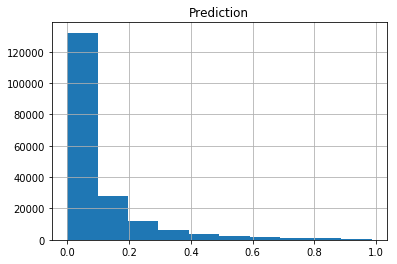

In [11]:
test_df[['Prediction']].hist()

Это решение дает 0.87126 на private и 0.86842 на public